In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Reading in the Data

In [3]:
yac_data = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/00_score_YAC/outputs/yac_tensor.csv")

In [4]:
yac_data.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId3,playId2,defenseId,offenseId,defense_s_x,defense_s_y,defense_receiver_x,defense_receiver_y,defense_receiver_s_x,defense_receiver_s_y,defense_offense_x,defense_offense_y,defense_offense_s_x,defense_offense_s_y
0,test,2018090600,75,79848,310,1,1,1,1,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,14.36,-21.26,0.990914,-7.093648
1,test,2018090600,75,79848,2533040,1,1,1,2,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,-4.99,-12.48,0.440893,-5.242125
2,test,2018090600,75,79848,2543583,1,1,1,3,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,7.56,-18.09,-1.830409,-7.239366
3,test,2018090600,75,79848,2555415,1,1,1,4,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,-4.04,-35.77,0.947049,-14.432378
4,test,2018090600,75,79848,2559033,1,1,1,5,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,4.54,-41.07,-0.300644,-12.685908
5,test,2018090600,75,0,0,1,1,1,6,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
6,test,2018090600,75,0,0,1,1,1,7,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
7,test,2018090600,75,0,0,1,1,1,8,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
8,test,2018090600,75,0,0,1,1,1,9,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
9,test,2018090600,75,0,0,1,1,1,10,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000


In [5]:
yac_data.shape

(2332440, 19)

In [6]:
target_data = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/00_score_YAC/outputs/yac_target.csv")

In [7]:
target_data.head(10)

,group,gameId,playId,playId2,playId3,yards_after_catch,yards_after_catch_adj
0,test,2018090600,75,1,1,2,2
1,test,2018090600,1037,2,9,0,0
2,test,2018090600,1202,3,12,0,0
3,test,2018090600,1916,4,19,3,3
4,test,2018090600,2624,5,25,3,3
5,test,2018090600,2648,6,26,4,4
6,test,2018090600,3507,7,31,1,1
7,test,2018090600,3979,8,36,4,4
8,test,2018090900,95,9,43,6,6
9,test,2018090900,622,10,47,10,10


# Formatting the Data

In [8]:
yac_data.columns

Index(['group', 'gameId', 'playId', 'defense_nflId', 'offense_nflId',
       'playId3', 'playId2', 'defenseId', 'offenseId', 'defense_s_x',
       'defense_s_y', 'defense_receiver_x', 'defense_receiver_y',
       'defense_receiver_s_x', 'defense_receiver_s_y', 'defense_offense_x',
       'defense_offense_y', 'defense_offense_s_x', 'defense_offense_s_y'],
      dtype='object')

In [9]:
def create_x(data, nfeatures):
    # creating a numpy tensor to hold the play data
    np_mat = np.array(data.drop(['group', 'gameId', 'playId', 'playId3','defense_nflId', 'offense_nflId'],
                               axis = 1))
    
    # setting parameters
    ngames = np.max(np.array(data['playId2']))
    nDef = 11
    nOff = 10
    
    # initializing the tensor
    np_tensor = np.zeros((ngames, nDef, nOff, nfeatures))
    
    for row in range(len(np_mat)):
        np_tensor[int(np_mat[row][0]) - 1][int(np_mat[row][1]) - 1][int(np_mat[row][2]) - 1] = np_mat[row][3:]
    
    np_tensor = np_tensor.astype('float32')
    
    return(np_tensor)

In [10]:
X_train = create_x(data = yac_data[yac_data["group"] == "training"],
                  nfeatures = 10)

In [11]:
X_train.shape

(14840, 11, 10, 10)

In [12]:
X_train[0][0][0]

array([  2.9290879 ,   0.95228356, -12.12      , -16.44      ,
        -2.722963  ,  -4.0835104 ,  21.63      ,   0.75      ,
         0.72488695,   2.4412758 ], dtype=float32)

In [13]:
X_validation = create_x(data = yac_data[(yac_data["group"] == "validation")&(yac_data["gameId"] < 20000000000)],
                  nfeatures = 10)

In [14]:
X_validation.shape

(1591, 11, 10, 10)

In [15]:
X_validation[0][0][0]

array([-1.1534169,  5.2856154, -4.34     ,  8.88     , -3.6358194,
        1.4129318,  7.41     ,  4.89     , -0.9907903,  1.2188658],
      dtype=float32)

In [16]:
X_test = create_x(data = yac_data[(yac_data["group"] == "test")&(yac_data["gameId"] < 20000000000)],
                  nfeatures = 10)

In [17]:
X_test.shape

(1591, 11, 10, 10)

In [18]:
X_test[0][0][0]

array([  1.7334098 ,  -7.7484765 ,  -0.26      ,   1.05      ,
         1.6353252 ,  -2.8194525 ,  14.36      , -21.26      ,
         0.99091405,  -7.0936484 ], dtype=float32)

In [19]:
def create_y(data):
    targets = np.array(data["yards_after_catch_adj"])
    
    y = np.zeros((targets.shape[0], 199))
    for idx, target in enumerate(list(targets)):
        y[idx][99 + target] = 1
    
    return(y)

In [20]:
y_train = create_y(data = target_data[(target_data["group"] == "training")])

In [21]:
y_train.shape

(14840, 199)

In [22]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
y_validation = create_y(data = target_data[(target_data["group"] == "validation")&(target_data["gameId"] < 20000000000)])

In [24]:
y_validation.shape

(1591, 199)

In [25]:
y_test = create_y(data = target_data[(target_data["group"] == "test") & (target_data["gameId"] < 20000000000)])

In [26]:
y_test.shape

(1591, 199)

In [27]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Training a Convolutional Neural Network Model

In [28]:
model = tf.keras.Sequential()

In [29]:
# first convolutional neural network
model.add(layers.Conv2D(128, 
                        kernel_size=(1,1), 
                        strides=(1,1), 
                        input_shape = (11,10,10)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(160, 
                        kernel_size=(1,1), 
                        strides=(1,1)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, 
                        kernel_size=(1,1), 
                        strides=(1,1)))
model.add(layers.Activation('relu'))

import tensorflow.keras.backend as K

def channelPool(x):
    return .5*K.max(x,axis=2) + .5*K.mean(x,axis=2)

model.add(layers.Lambda(channelPool))

In [30]:
# second convolutional neural network
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(160, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(196, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(196, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
# model.add(layers.AvgPool2D(pool_size=(11, 1)))

def channelPool(x):
    return .5*K.max(x,axis=1) + .5*K.mean(x,axis=1)

model.add(layers.Lambda(channelPool))

In [31]:
model.add(layers.Flatten())
model.add(layers.Dense(96))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(199))
model.add(layers.Activation('softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 10, 128)       1408      
_________________________________________________________________
activation (Activation)      (None, 11, 10, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 10, 160)       20640     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 10, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 10, 128)       20608     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 10, 128)       0         
_________________________________________________________________
lambda (Lambda)              (None, 11, 128)           0

In [33]:
import tensorflow.keras.backend as K
def crps(y_true, y_pred):
    y_pred =  K.cumsum(y_pred, axis=1)
    ym =  K.cast(K.reshape(K.argmax(y_true, axis=1) - 99, (-1, 1)), 
        dtype='int32')
    n = K.arange(-99, 100)
    step = K.cast(K.greater_equal(n - ym, 0), dtype='float32')
    return K.mean(K.sum(K.square(y_pred - step), axis=1)) / 199

In [34]:
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint

In [35]:
from tensorflow.keras.optimizers import Adam
model.compile(loss=[crps], metrics=[crps], optimizer='adam')

In [36]:
history = model.fit(X_train, y_train,
                   validation_data = (X_validation, y_validation),
                   # batch_size = 64,
                   epochs = 20,
                   verbose = 1)

Epoch 1/20
464/464 [==============================] - 20s 44ms/step - loss: 0.0186 - crps: 0.0186 - val_loss: 0.0132 - val_crps: 0.0132
Epoch 2/20
464/464 [==============================] - 20s 44ms/step - loss: 0.0134 - crps: 0.0134 - val_loss: 0.0125 - val_crps: 0.0125
Epoch 3/20
464/464 [==============================] - 20s 43ms/step - loss: 0.0127 - crps: 0.0127 - val_loss: 0.0115 - val_crps: 0.0115
Epoch 4/20
464/464 [==============================] - 15s 32ms/step - loss: 0.0122 - crps: 0.0122 - val_loss: 0.0119 - val_crps: 0.0119
Epoch 5/20
464/464 [==============================] - 14s 31ms/step - loss: 0.0120 - crps: 0.0120 - val_loss: 0.0117 - val_crps: 0.0117
Epoch 6/20
464/464 [==============================] - 14s 31ms/step - loss: 0.0118 - crps: 0.0118 - val_loss: 0.0114 - val_crps: 0.0114
Epoch 7/20
464/464 [==============================] - 15s 31ms/step - loss: 0.0117 - crps: 0.0117 - val_loss: 0.0111 - val_crps: 0.0111
Epoch 8/20
464/464 [============================

In [37]:
model.evaluate(X_test, y_test)

50/50 [==============================] - 0s 10ms/step - loss: 0.0114 - crps: 0.0114


[0.011418686248362064, 0.011406375095248222]

# Examining Results

The plays analyzed are part of the holdout set, so the CNN model did not ever see the data in training, or indirectly through optimizing the crps of the cross-validation set.

### Play that Went For Negative Yardage

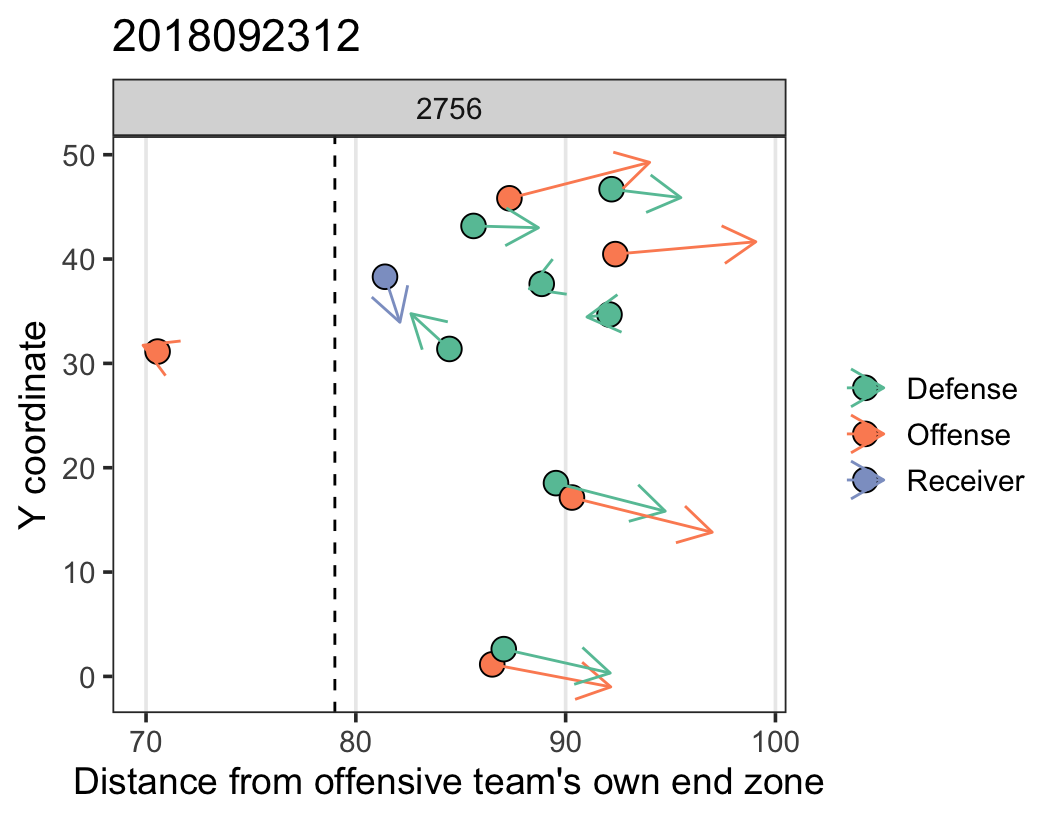

In [38]:
yac_data[(yac_data["gameId"] == 2018092312) & (yac_data["playId"] == 2756)]["playId2"].iloc[0]

301

In [39]:
yards = target_data[(target_data["gameId"] == 2018092312) & (target_data["playId"] == 2756)]["yards_after_catch"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a -2 gain.


In [40]:
np.argmax(y_test[301-1]) - 99

-2

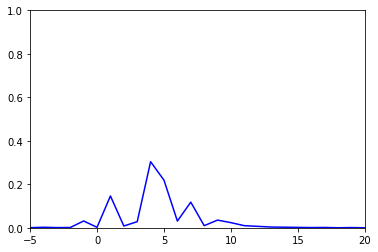

In [41]:
plt.plot(np.arange(-99,100), model.predict(X_test)[300], 'b-')
plt.xlim(-5,20)
plt.ylim(0,1)
plt.show()

In [42]:
# yardage prediction
model.predict(X_test)[300].dot(np.arange(-99,100))

4.656472069433676

### Play that Went For No Yardage

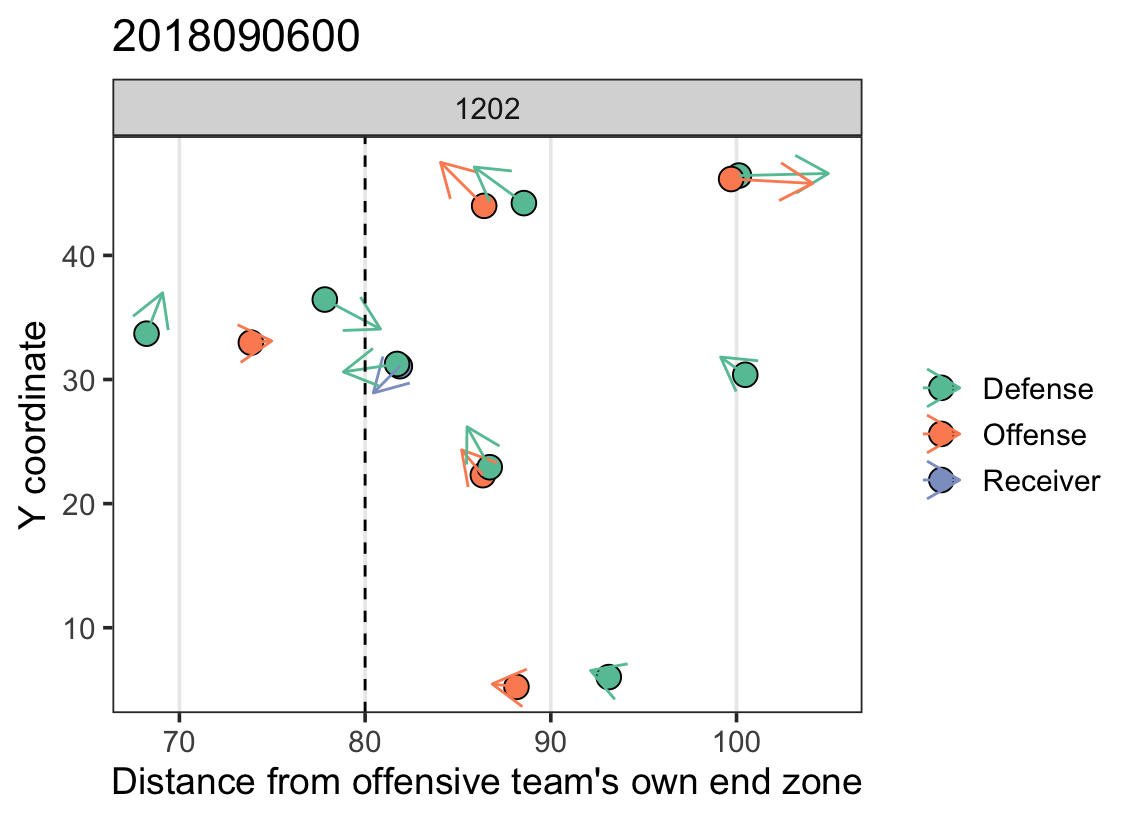

In [43]:
yac_data[(yac_data["gameId"] == 2018090600) & (yac_data["playId"] == 1202)]["playId2"].iloc[0]

3

In [44]:
yards = target_data[(target_data["gameId"] == 2018090600) & (target_data["playId"] == 1202)]["yards_after_catch"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 0 gain.


In [45]:
np.argmax(y_test[3-1]) - 99

0

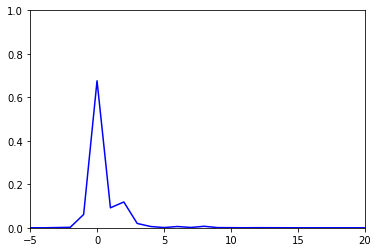

In [46]:
plt.plot(np.arange(-99,100), model.predict(X_test)[2], 'b-')
plt.xlim(-5,20)
plt.ylim(0,1)
plt.show()

In [47]:
# yardage prediction
model.predict(X_test)[2].dot(np.arange(-99,100))

0.4908340930921895

### Play that Went For 5 Yards

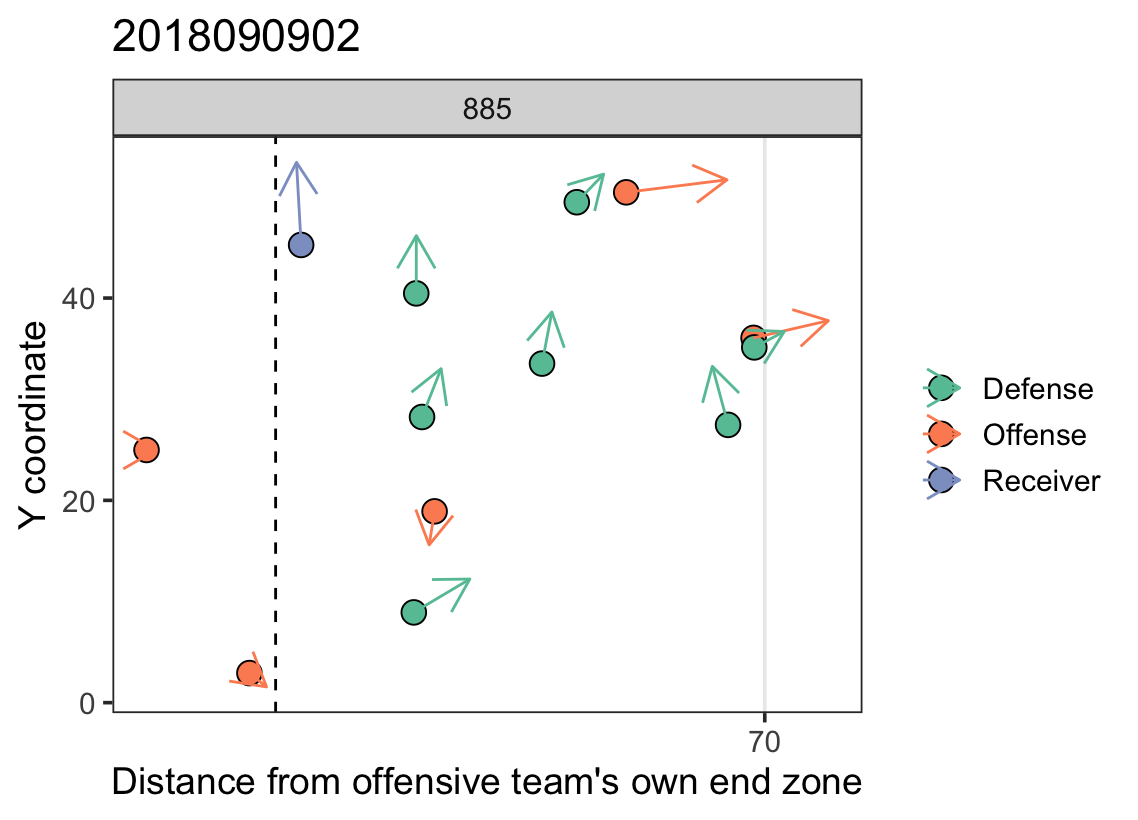

In [48]:
yac_data[(yac_data["gameId"] == 2018090902) & (yac_data["playId"] == 885)]["playId2"].iloc[0]

25

In [49]:
yards = target_data[(target_data["gameId"] == 2018090902) & (target_data["playId"] == 885)]["yards_after_catch"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 5 gain.


In [50]:
np.argmax(y_test[25-1]) - 99

5

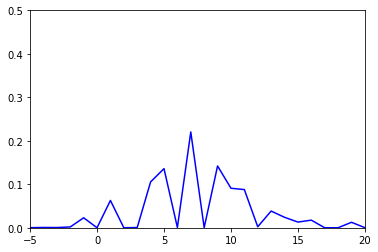

In [51]:
plt.plot(np.arange(-99,100), model.predict(X_test)[24], 'b-')
plt.xlim(-5,20)
plt.ylim(0,.5)
plt.show()

In [52]:
# yardage prediction
model.predict(X_test)[24].dot(np.arange(-99,100))

7.7985043485909955

### Play that Went For 10 Yards

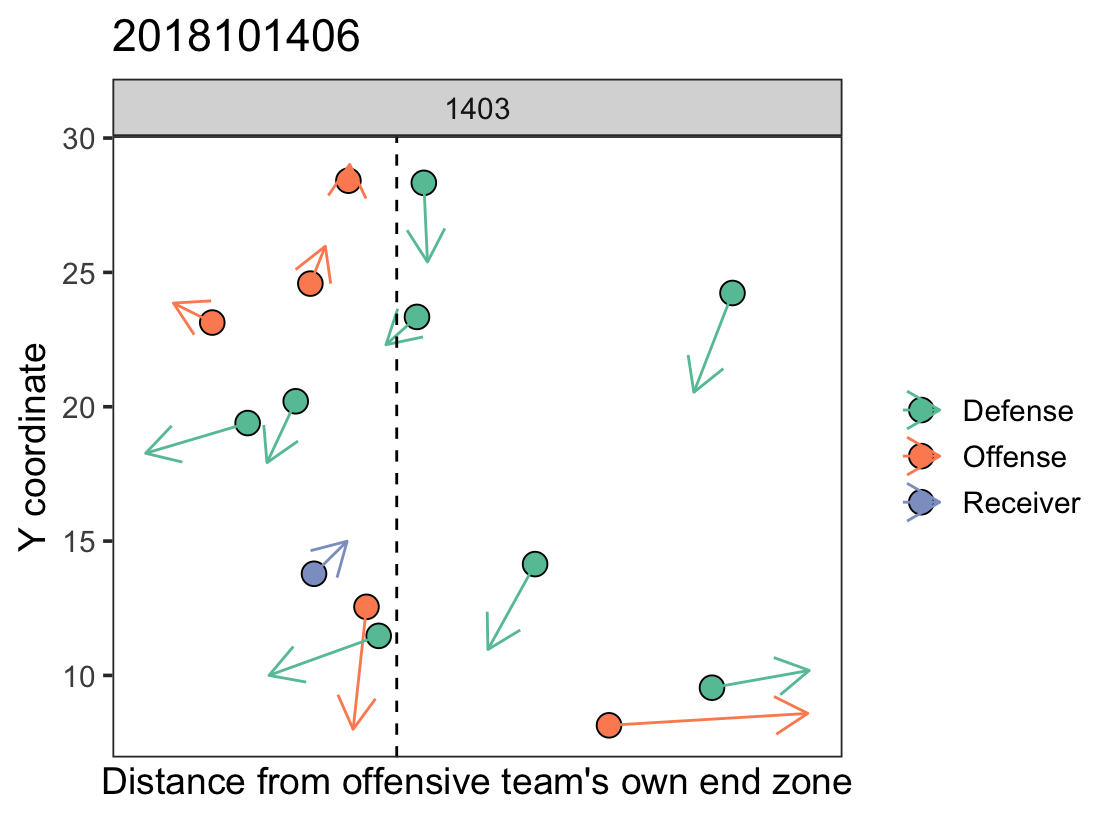

In [53]:
yac_data[(yac_data["gameId"] == 2018101406) & (yac_data["playId"] == 1403)]["playId2"].iloc[0]

568

In [54]:
yards = target_data[(target_data["gameId"] == 2018101406) & (target_data["playId"] == 1403)]["yards_after_catch"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 10 gain.


In [55]:
np.argmax(y_test[568-1]) - 99

10

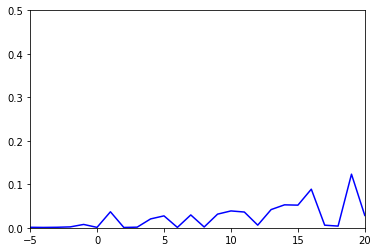

In [56]:
plt.plot(np.arange(-99,100), model.predict(X_test)[567], 'b-')
plt.xlim(-5,20)
plt.ylim(0,.5)
plt.show()

In [57]:
# yardage prediction
model.predict(X_test)[567].dot(np.arange(-99,100))

18.26187568987916

### Play that Went For 30+ Yards

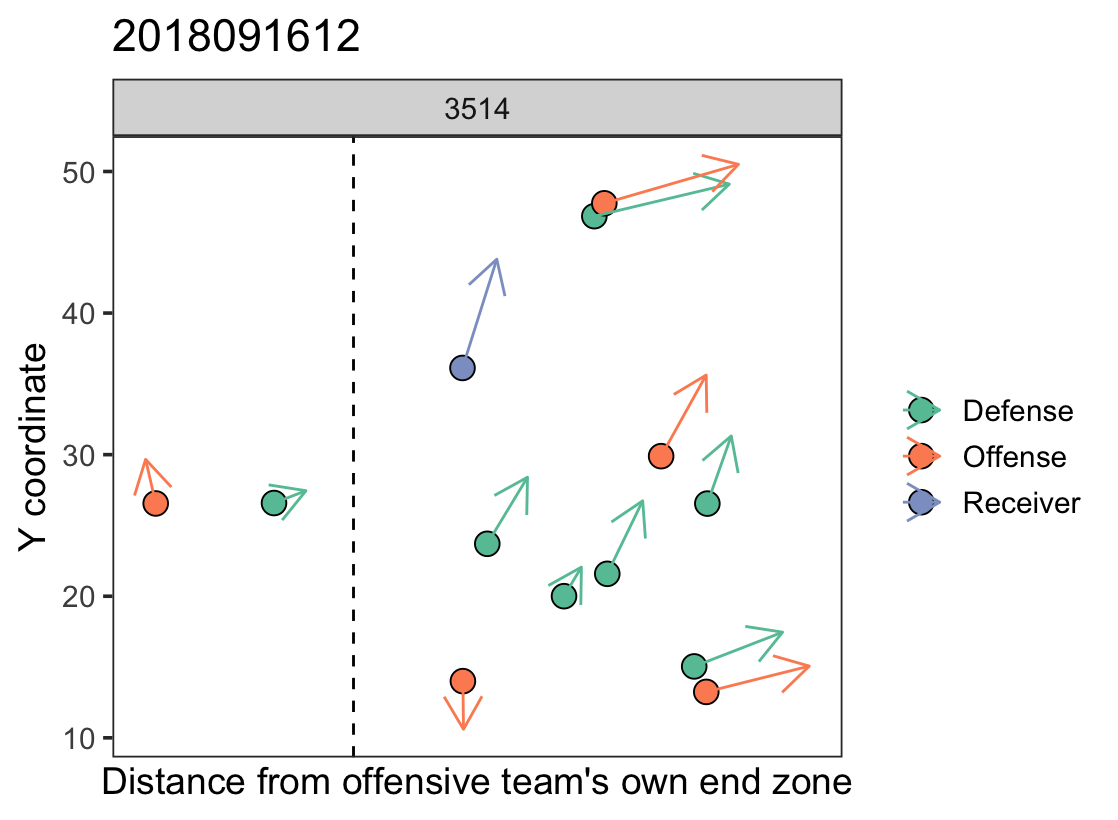

In [58]:
yac_data[(yac_data["gameId"] == 2018091612) & (yac_data["playId"] == 3514)]["playId2"].iloc[0]

192

In [59]:
yards = target_data[(target_data["gameId"] == 2018091612) & (target_data["playId"] == 3514)]["yards_after_catch"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 56 gain.


In [60]:
np.argmax(y_test[192-1]) - 99

50

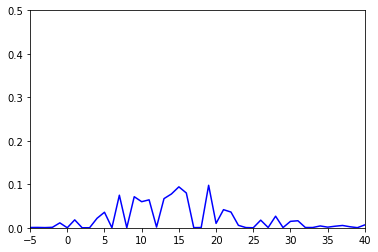

In [61]:
plt.plot(np.arange(-99,100), model.predict(X_test)[191], 'b-')
plt.xlim(-5,40)
plt.ylim(0,.5)
plt.show()

In [62]:
# yardage prediction
model.predict(X_test)[191].dot(np.arange(-99,100))

15.118365242938125

# Scoring Entire Data Set

In [63]:
yac_data_score = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/00_score_YAC/outputs/yac_tensor_score.csv")

In [64]:
yac_data_score.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId2,defenseId,offenseId,defense_s_x,defense_s_y,defense_receiver_x,defense_receiver_y,defense_receiver_s_x,defense_receiver_s_y,defense_offense_x,defense_offense_y,defense_offense_s_x,defense_offense_s_y
0,full,2018090600,75,79848,310,1,1,1,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,14.36,-21.26,0.990914,-7.093648
1,full,2018090600,75,79848,2533040,1,1,2,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,-4.99,-12.48,0.440893,-5.242125
2,full,2018090600,75,79848,2543583,1,1,3,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,7.56,-18.09,-1.830409,-7.239366
3,full,2018090600,75,79848,2555415,1,1,4,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,-4.04,-35.77,0.947049,-14.432378
4,full,2018090600,75,79848,2559033,1,1,5,1.733410,-7.748477,-0.26,1.05,1.635325,-2.819452,4.54,-41.07,-0.300644,-12.685908
5,full,2018090600,75,0,0,1,1,6,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
6,full,2018090600,75,0,0,1,1,7,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
7,full,2018090600,75,0,0,1,1,8,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
8,full,2018090600,75,0,0,1,1,9,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
9,full,2018090600,75,0,0,1,1,10,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000


In [65]:
yac_data_score.shape

(1195840, 18)

In [66]:
target_data_score = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/00_score_YAC/outputs/yac_target_score.csv")

In [67]:
target_data_score.head(10)

,group,gameId,playId,playId2,yards_after_catch,yards_after_catch_adj
0,full,2018090600,75,1,2,2
1,full,2018090600,190,2,9,9
2,full,2018090600,320,3,0,0
3,full,2018090600,492,4,35,35
4,full,2018090600,521,5,1,1
5,full,2018090600,752,6,1,1
6,full,2018090600,949,7,0,0
7,full,2018090600,992,8,2,2
8,full,2018090600,1037,9,0,0
9,full,2018090600,1061,10,1,1


# Formatting the Data

In [68]:
yac_data_score.columns

Index(['group', 'gameId', 'playId', 'defense_nflId', 'offense_nflId',
       'playId2', 'defenseId', 'offenseId', 'defense_s_x', 'defense_s_y',
       'defense_receiver_x', 'defense_receiver_y', 'defense_receiver_s_x',
       'defense_receiver_s_y', 'defense_offense_x', 'defense_offense_y',
       'defense_offense_s_x', 'defense_offense_s_y'],
      dtype='object')

In [69]:
def create_x(data, nfeatures):
    # creating a numpy tensor to hold the play data
    np_mat = np.array(data.drop(['group', 'gameId', 'playId','defense_nflId', 'offense_nflId'],
                               axis = 1))
    
    # setting parameters
    ngames = np.max(np.array(data['playId2']))
    nDef = 11
    nOff = 10
    
    # initializing the tensor
    np_tensor = np.zeros((ngames, nDef, nOff, nfeatures))
    
    for row in range(len(np_mat)):
        np_tensor[int(np_mat[row][0]) - 1][int(np_mat[row][1]) - 1][int(np_mat[row][2]) - 1] = np_mat[row][3:]
    
    np_tensor = np_tensor.astype('float32')
    
    return(np_tensor)

In [70]:
X_score = create_x(data = yac_data_score,
                  nfeatures = 10)

In [71]:
X_score.shape

(10764, 11, 10, 10)

In [72]:
X_score[0][0][0]

array([  1.7334098 ,  -7.7484765 ,  -0.26      ,   1.05      ,
         1.6353252 ,  -2.8194525 ,  14.36      , -21.26      ,
         0.99091405,  -7.0936484 ], dtype=float32)

In [73]:
def create_y(data):
    targets = np.array(data["yards_after_catch_adj"])
    
    y = np.zeros((targets.shape[0], 199))
    for idx, target in enumerate(list(targets)):
        y[idx][99 + target] = 1
    
    return(y)

In [74]:
y_score = create_y(data = target_data_score)

In [75]:
y_score.shape

(10764, 199)

In [76]:
y_score[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Saving Predictions

In [77]:
score_preds = model.predict(X_score)

In [78]:
model.evaluate(X_score, y_score)

337/337 [==============================] - 3s 8ms/step - loss: 0.0111 - crps: 0.0111


[0.011126825585961342, 0.011117639020085335]

In [79]:
score_preds[0][0:10]

array([7.84157146e-06, 1.01207061e-05, 6.81628126e-06, 8.71856355e-06,
       6.32522733e-06, 7.40517953e-06, 1.25985462e-05, 1.40568918e-05,
       1.27836365e-05, 1.28495785e-05], dtype=float32)

In [80]:
full_preds_df = pd.DataFrame(score_preds, columns = [str(int(x - 99)) for x in np.linspace(0,198, 199)])

In [81]:
full_preds_df.shape

(10764, 199)

In [82]:
full_preds_df2 = pd.concat([target_data_score, full_preds_df], axis = 1).drop(["group", 
                                                                              "yards_after_catch_adj",
                                                                              "yards_after_catch",
                                                                              "playId2"], axis = 1)
full_preds_df2 = full_preds_df2[full_preds_df2["gameId"] < 10000000000]

In [83]:
full_preds_df2.shape

(10764, 201)

In [84]:
full_preds_df2.head(10)

,gameId,playId,-99,-98,-97,-96,-95,-94,-93,-92,...,90,91,92,93,94,95,96,97,98,99
0,2018090600,75,7.841571e-06,1.012071e-05,6.816281e-06,8.718564e-06,6.325227e-06,7.405180e-06,1.259855e-05,1.405689e-05,...,5.082279e-06,1.181568e-05,4.158678e-06,7.126730e-06,4.918469e-06,5.094158e-06,1.490917e-05,6.149241e-06,9.605789e-06,9.564782e-06
1,2018090600,190,2.456186e-05,7.893660e-06,9.626215e-06,6.600566e-06,7.944623e-06,1.471649e-05,1.233580e-05,8.918854e-06,...,8.997511e-06,2.959235e-05,1.689166e-05,3.045448e-05,1.382348e-05,1.122053e-05,1.418997e-05,1.619710e-05,1.831897e-05,2.199979e-05
2,2018090600,320,2.265592e-09,8.702311e-17,8.706828e-17,5.372315e-16,1.685509e-13,6.968749e-10,1.013530e-16,1.561407e-15,...,1.606073e-17,2.763910e-14,1.317220e-17,1.198410e-16,4.465899e-17,8.020765e-18,1.064433e-16,5.838496e-15,2.943282e-15,9.641955e-17
3,2018090600,492,8.912054e-06,2.435720e-05,1.886684e-05,1.400875e-05,1.847332e-05,1.204697e-05,3.663157e-05,2.776257e-05,...,7.493081e-05,6.883271e-05,3.768816e-05,9.958455e-05,4.983266e-05,4.995471e-05,5.205407e-05,5.562634e-05,2.452390e-05,3.779549e-05
4,2018090600,521,1.779256e-05,1.637729e-05,3.011131e-05,1.095762e-05,9.937225e-06,1.232443e-05,1.748244e-05,9.251299e-06,...,1.027911e-05,3.089262e-05,9.167933e-06,8.645598e-06,1.355659e-05,1.692542e-05,2.363727e-05,1.064631e-05,1.712653e-05,2.155435e-05
5,2018090600,752,1.787050e-05,1.806538e-05,2.278313e-05,1.092571e-05,1.036424e-05,1.172916e-05,1.463037e-05,1.098953e-05,...,1.067459e-05,2.621117e-05,9.406273e-06,1.533700e-05,1.425565e-05,1.241408e-05,1.611464e-05,1.277350e-05,1.287222e-05,2.400717e-05
6,2018090600,949,9.270146e-06,4.623727e-05,4.461087e-05,2.403670e-05,2.050321e-05,1.359034e-05,6.320934e-05,3.945593e-05,...,3.982790e-05,1.936837e-05,3.736350e-05,3.581936e-05,2.874479e-05,7.988181e-05,2.711769e-05,1.914820e-05,2.415403e-05,3.460317e-05
7,2018090600,992,8.508670e-06,9.035209e-06,9.081816e-06,4.228841e-06,5.929634e-06,6.043854e-06,7.729293e-06,7.411457e-06,...,5.224721e-06,1.324947e-05,7.605833e-06,1.062289e-05,6.601675e-06,6.715921e-06,9.693614e-06,8.096105e-06,6.677290e-06,8.738279e-06
8,2018090600,1037,2.761880e-05,6.465618e-07,6.970176e-07,7.209466e-07,1.965609e-06,2.434779e-05,8.232550e-07,8.623304e-07,...,6.527325e-07,3.089915e-06,1.171479e-06,2.445555e-06,1.055205e-06,3.335387e-07,1.108222e-06,1.778009e-06,1.473532e-06,1.684618e-06
9,2018090600,1061,3.274641e-05,4.170730e-06,4.736963e-06,2.654713e-06,4.516951e-06,2.232852e-05,4.540464e-06,3.333581e-06,...,3.348065e-06,1.271497e-05,5.028093e-06,8.296892e-06,4.688330e-06,3.819725e-06,5.021303e-06,6.091581e-06,4.411214e-06,8.058168e-06


In [85]:
full_preds_df3 = pd.melt(full_preds_df2, 
        id_vars=['gameId', 'playId'], 
        value_vars=[str(int(x - 99)) for x in np.linspace(0,198, 199)],
        var_name='yards_after_catch', 
        value_name='probability')

full_preds_df3["yards_after_catch"] = [int(x) for x in np.array(full_preds_df3["yards_after_catch"])]
full_preds_df3 = full_preds_df3.sort_values(['gameId','playId','yards_after_catch'])

In [86]:
full_preds_df3.head(10)

,gameId,playId,yards_after_catch,probability
0,2018090600,75,-99,0.000008
10764,2018090600,75,-98,0.000010
21528,2018090600,75,-97,0.000007
32292,2018090600,75,-96,0.000009
43056,2018090600,75,-95,0.000006
53820,2018090600,75,-94,0.000007
64584,2018090600,75,-93,0.000013
75348,2018090600,75,-92,0.000014
86112,2018090600,75,-91,0.000013
96876,2018090600,75,-90,0.000013


In [89]:
full_preds_df3.shape

(2142036, 4)

In [90]:
full_preds_df3.to_csv("~/Desktop/CoverageNet/src/03_coverageNet/00_score_YAC/outputs/yac_predictions_completions.csv", 
                        index = False)

# Scoring Interceptions To Get Expected YAINT

## Reading in the Data

In [91]:
yaint_data = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/00_score_YAC/outputs/yaint_tensor.csv")

In [92]:
yaint_data.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId2,defenseId,offenseId,defense_s_x,defense_s_y,defense_receiver_x,defense_receiver_y,defense_receiver_s_x,defense_receiver_s_y,defense_offense_x,defense_offense_y,defense_offense_s_x,defense_offense_s_y
0,full,2018090600,3392,310,79848,1,1,1,1.491557,-2.977273,21.52,26.21,-0.989278,1.841633,5.23,-3.28,2.757751,-1.520684
1,full,2018090600,3392,310,2495613,1,1,2,1.491557,-2.977273,21.52,26.21,-0.989278,1.841633,15.61,2.86,-0.895857,1.597205
2,full,2018090600,3392,310,2534832,1,1,3,1.491557,-2.977273,21.52,26.21,-0.989278,1.841633,1.84,-5.25,1.361910,-2.577784
3,full,2018090600,3392,310,2552315,1,1,4,1.491557,-2.977273,21.52,26.21,-0.989278,1.841633,2.69,-3.80,1.491847,-1.317273
4,full,2018090600,3392,310,2555383,1,1,5,1.491557,-2.977273,21.52,26.21,-0.989278,1.841633,27.78,-17.19,1.836172,-3.563482
5,full,2018090600,3392,310,2557958,1,1,6,1.491557,-2.977273,21.52,26.21,-0.989278,1.841633,16.00,7.25,1.159347,-5.344072
6,full,2018090600,3392,0,0,1,1,7,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
7,full,2018090600,3392,0,0,1,1,8,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
8,full,2018090600,3392,0,0,1,1,9,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
9,full,2018090600,3392,0,0,1,1,10,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000


In [93]:
yaint_data.shape

(39270, 18)

In [97]:
target_data = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/00_score_YAC/outputs/yaint_target.csv")

In [98]:
target_data.head(10)

,group,gameId,playId,playId2,yards_after_catch,yards_after_catch_adj
0,full,2018090600,3392,1,0,0
1,full,2018090600,3481,2,20,20
2,full,2018090900,1869,3,15,15
3,full,2018090900,2845,4,32,32
4,full,2018090901,704,5,0,0
5,full,2018090901,1516,6,0,0
6,full,2018090901,1912,7,26,26
7,full,2018090901,4495,8,0,0
8,full,2018090902,81,9,32,32
9,full,2018090902,163,10,2,2


# Formatting the Data

In [99]:
yaint_data.columns

Index(['group', 'gameId', 'playId', 'defense_nflId', 'offense_nflId',
       'playId2', 'defenseId', 'offenseId', 'defense_s_x', 'defense_s_y',
       'defense_receiver_x', 'defense_receiver_y', 'defense_receiver_s_x',
       'defense_receiver_s_y', 'defense_offense_x', 'defense_offense_y',
       'defense_offense_s_x', 'defense_offense_s_y'],
      dtype='object')

In [100]:
def create_x(data, nfeatures):
    # creating a numpy tensor to hold the play data
    np_mat = np.array(data.drop(['group', 'gameId', 'playId', 'defense_nflId', 'offense_nflId'],
                               axis = 1))
    
    # setting parameters
    ngames = np.max(np.array(data['playId2']))
    nDef = 11
    nOff = 10
    
    # initializing the tensor
    np_tensor = np.zeros((ngames, nDef, nOff, nfeatures))
    
    for row in range(len(np_mat)):
        np_tensor[int(np_mat[row][0]) - 1][int(np_mat[row][1]) - 1][int(np_mat[row][2]) - 1] = np_mat[row][3:]
    
    np_tensor = np_tensor.astype('float32')
    
    return(np_tensor)

In [101]:
X_full = create_x(data = yaint_data,
                  nfeatures = 10)

In [102]:
X_full.shape

(357, 11, 10, 10)

In [103]:
X_full[0][0][0]

array([ 1.4915574, -2.9772732, 21.52     , 26.21     , -0.9892782,
        1.8416326,  5.23     , -3.28     ,  2.7577512, -1.5206839],
      dtype=float32)

In [104]:
def create_y(data):
    targets = np.array(data["yards_after_catch_adj"])
    
    y = np.zeros((targets.shape[0], 199))
    for idx, target in enumerate(list(targets)):
        y[idx][99 + target] = 1
    
    return(y)

In [105]:
y_target = create_y(data = target_data)

In [106]:
y_target.shape

(357, 199)

In [107]:
y_target[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Look at model applicability

In [108]:
model.evaluate(X_full, y_target)

12/12 [==============================] - 0s 10ms/step - loss: 0.0380 - crps: 0.0379


[0.03797196224331856, 0.03785399720072746]

# Examining Results

Analyzing the same plays again, but this time using the results from the model trained on the entirety of the data set (and their flipped counterparts).

### Play that Went For Negative Yardage

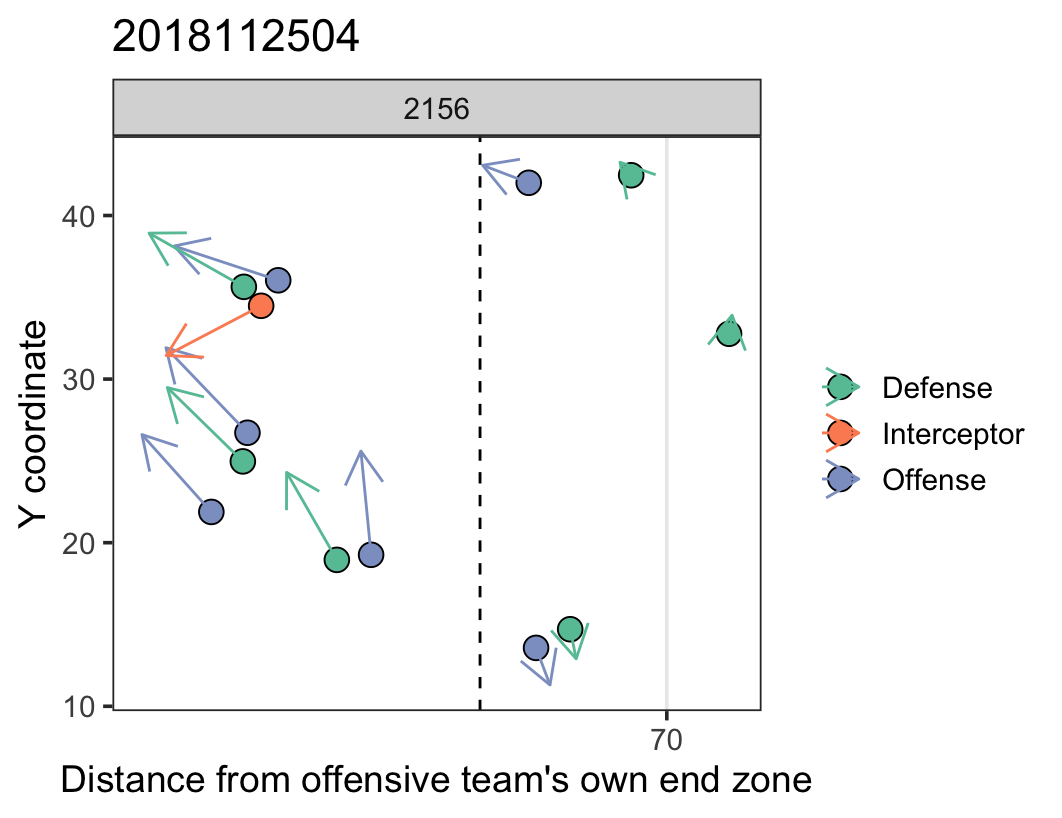

In [109]:
yaint_data[(yaint_data["gameId"] == 2018112504) & (yaint_data["playId"] == 2156)]["playId2"].iloc[0]

243

In [110]:
yards = target_data[(target_data["gameId"] == 2018112504) & (target_data["playId"] == 2156)]["yards_after_catch"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a -7 gain.


In [111]:
np.argmax(y_target[243-1]) - 99

-7

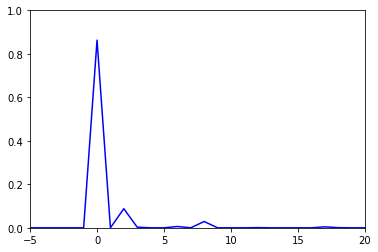

In [112]:
plt.plot(np.arange(-99,100), model.predict(X_full)[242], 'b-')
plt.xlim(-5,20)
plt.ylim(0,1)
plt.show()

In [113]:
# yardage prediction
model.predict(X_full)[242].dot(np.arange(-99,100))

0.6570666864014925

### Play that Went For 20+ yards

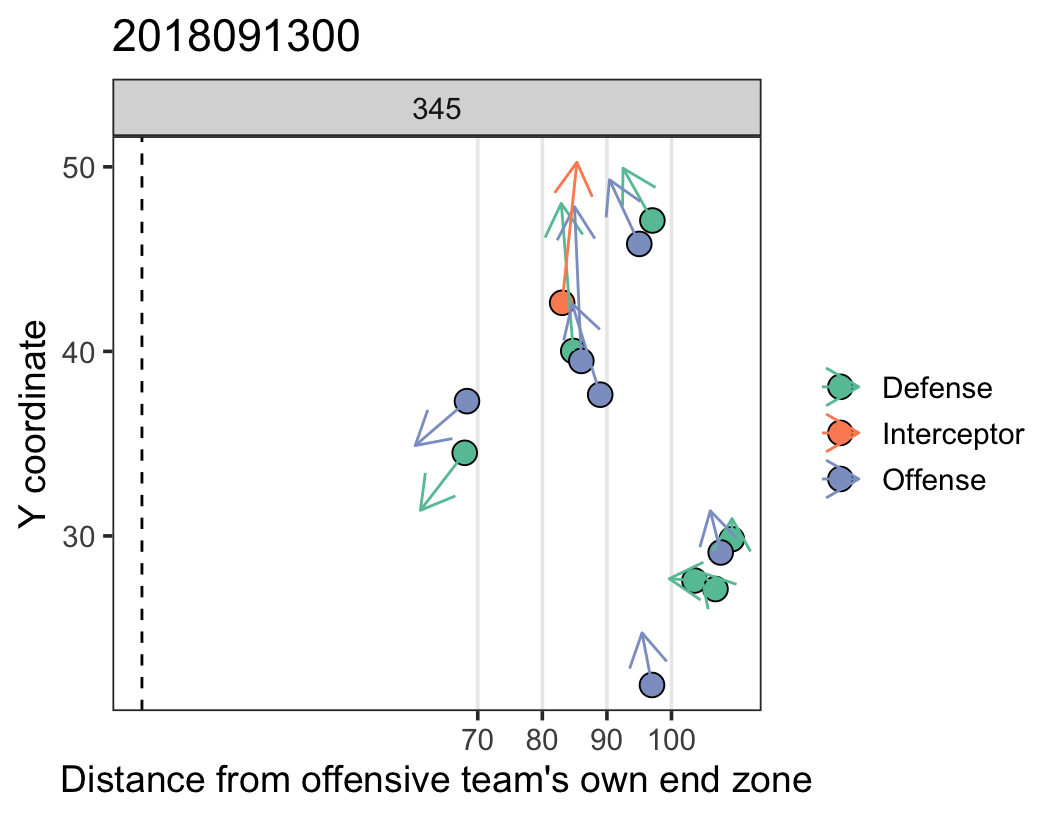

In [114]:
yaint_data[(yaint_data["gameId"] == 2018091300) & (yaint_data["playId"] == 345)]["playId2"].iloc[0]

28

In [115]:
yards = target_data[(target_data["gameId"] == 2018091300) & (target_data["playId"] == 345)]["yards_after_catch"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 21 gain.


In [116]:
np.argmax(y_target[28-1]) - 99

21

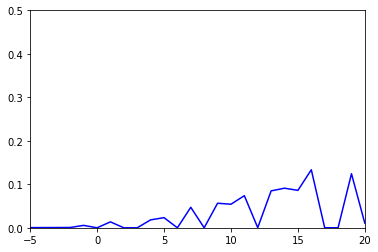

In [117]:
plt.plot(np.arange(-99,100), model.predict(X_full)[27], 'b-')
plt.xlim(-5,20)
plt.ylim(0,.5)
plt.show()

In [118]:
# yardage prediction
model.predict(X_full)[27].dot(np.arange(-99,100))

15.34605322795278

# Saving Predictions

In [119]:
int_preds = model.predict(X_full)

In [120]:
int_preds[0][0:10]

array([2.7401235e-05, 2.5411309e-05, 2.3108769e-05, 1.3820318e-05,
       1.6515643e-05, 1.7448690e-05, 3.2348802e-05, 2.6964533e-05,
       2.2909220e-05, 2.6569282e-05], dtype=float32)

In [121]:
int_preds_df = pd.DataFrame(int_preds, columns = [str(int(x - 99)) for x in np.linspace(0,198, 199)])

In [122]:
int_preds_df.shape

(357, 199)

In [123]:
int_preds_df2 = pd.concat([target_data, int_preds_df], axis = 1).drop(["group", 
                                                                              "yards_after_catch_adj",
                                                                              "yards_after_catch",
                                                                              "playId2"], axis = 1)
int_preds_df2 = int_preds_df2[int_preds_df2["gameId"] < 10000000000]

In [124]:
int_preds_df2.shape

(357, 201)

In [125]:
int_preds_df2.head(10)

,gameId,playId,-99,-98,-97,-96,-95,-94,-93,-92,...,90,91,92,93,94,95,96,97,98,99
0,2018090600,3392,2.740123e-05,2.541131e-05,2.310877e-05,1.382032e-05,1.651564e-05,1.744869e-05,3.234880e-05,2.696453e-05,...,3.772376e-05,8.255689e-05,3.668222e-05,1.246560e-04,4.241073e-05,4.172638e-05,6.056233e-05,6.085152e-05,4.553228e-05,4.885040e-05
1,2018090600,3481,1.179664e-05,1.867353e-05,1.715336e-05,9.709001e-06,1.286926e-05,1.192753e-05,1.590548e-05,1.396934e-05,...,1.521588e-05,2.633453e-05,1.858298e-05,2.967438e-05,1.656747e-05,1.985516e-05,2.301607e-05,1.898198e-05,1.942589e-05,1.529957e-05
2,2018090900,1869,2.893672e-05,2.391038e-05,1.108759e-05,2.129368e-05,4.166184e-05,4.604229e-05,3.430986e-05,4.968611e-05,...,1.332982e-04,3.226867e-04,9.827854e-05,3.323392e-04,6.410891e-05,1.330496e-04,1.055110e-04,4.725882e-04,9.273270e-05,1.563153e-04
3,2018090900,2845,1.056719e-05,1.738731e-05,1.740739e-05,8.527370e-06,1.085925e-05,1.054401e-05,1.652540e-05,1.260815e-05,...,1.358913e-05,2.187304e-05,1.714912e-05,2.360501e-05,1.430304e-05,1.722425e-05,2.029931e-05,1.760576e-05,1.468944e-05,1.342665e-05
4,2018090901,704,8.921026e-06,1.175274e-05,1.599201e-05,7.499981e-06,6.510747e-06,9.409056e-06,1.079143e-05,9.833046e-06,...,1.642780e-05,2.898216e-05,1.746777e-05,3.080792e-05,1.962775e-05,1.689246e-05,1.747634e-05,1.977022e-05,1.665795e-05,2.520416e-05
5,2018090901,1516,4.296415e-05,1.855115e-05,2.583444e-05,1.726129e-05,2.809835e-05,4.030338e-05,4.446727e-05,3.810393e-05,...,4.268308e-05,1.003212e-04,6.174365e-05,1.455328e-04,5.781612e-05,3.462791e-05,5.850428e-05,1.088057e-04,5.185886e-05,7.687735e-05
6,2018090901,1912,1.095562e-05,1.114822e-05,1.570006e-05,8.984439e-06,6.020115e-06,1.411201e-05,1.245673e-05,8.380186e-06,...,1.336167e-05,3.503358e-05,1.121293e-05,1.938983e-05,1.667788e-05,1.443868e-05,2.087795e-05,1.552043e-05,2.014451e-05,2.295815e-05
7,2018090901,4495,9.820272e-07,1.987128e-09,1.447547e-09,1.504685e-09,2.070157e-08,7.643296e-07,2.485643e-09,6.460660e-09,...,2.012616e-09,2.811692e-08,1.567765e-09,1.299238e-08,2.445221e-09,4.121175e-10,5.168207e-09,3.189160e-08,6.482211e-09,4.995440e-09
8,2018090902,81,3.709586e-05,3.879527e-05,2.627003e-05,3.135684e-05,3.318755e-05,2.587045e-05,7.265077e-05,5.382745e-05,...,1.977353e-04,2.770669e-04,1.423343e-04,5.198314e-04,1.787919e-04,1.419741e-04,2.420167e-04,3.782370e-04,1.099666e-04,9.975630e-05
9,2018090902,163,1.421562e-05,2.513581e-05,2.764775e-05,1.768676e-05,2.065134e-05,1.522587e-05,3.367689e-05,2.653870e-05,...,3.310739e-05,4.349328e-05,2.740362e-05,3.744609e-05,2.771015e-05,3.343598e-05,4.181671e-05,2.295835e-05,3.976203e-05,2.641006e-05


In [126]:
int_preds_df3 = pd.melt(int_preds_df2, 
        id_vars=['gameId', 'playId'], 
        value_vars=[str(int(x - 99)) for x in np.linspace(0,198, 199)],
        var_name='yards_after_catch', 
        value_name='probability')

int_preds_df3["yards_after_catch"] = [int(x) for x in np.array(int_preds_df3["yards_after_catch"])]
int_preds_df3 = int_preds_df3.sort_values(['gameId','playId','yards_after_catch'])

In [127]:
int_preds_df3.head(10)

,gameId,playId,yards_after_catch,probability
0,2018090600,3392,-99,0.000027
357,2018090600,3392,-98,0.000025
714,2018090600,3392,-97,0.000023
1071,2018090600,3392,-96,0.000014
1428,2018090600,3392,-95,0.000017
1785,2018090600,3392,-94,0.000017
2142,2018090600,3392,-93,0.000032
2499,2018090600,3392,-92,0.000027
2856,2018090600,3392,-91,0.000023
3213,2018090600,3392,-90,0.000027


In [128]:
int_preds_df3.shape

(71043, 4)

In [129]:
int_preds_df3.to_csv("~/Desktop/CoverageNet/src/03_coverageNet/00_score_YAC/outputs/yaint_predictions_interceptions.csv", 
                        index = False)